In [1]:
import numpy as np 

from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt

np.random.seed(1847)

class BatchSampler(object):
    '''
    A (very) simple wrapper to randomly sample batches without replacement.

    You shouldn't need to touch this.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.batch_size = batch_size

        self.data = data
        self.targets = targets

        self.indices = np.arange(self.num_points)

    def random_batch_indices(self, m=None):
        '''
        Get random batch indices without replacement from the dataset.

        If m is given the batch will be of size m. Otherwise will default to the class initialized value.
        '''
        if m is None:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.random.choice(self.indices, m, replace=False)
        return indices 

    def get_batch(self, m=None):
        '''
        Get a random batch without replacement from the dataset.

        If m is given the batch will be of size m. Otherwise will default to the class initialized value.
        '''
        indices = self.random_batch_indices(m)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch  

In [2]:
class GDOptimizer(object):
    '''
    A gradient descent optimizer with momentum
    '''

    def __init__(self, lr, beta=0.0):
        self.lr = lr
        self.beta = beta
        self.delta = 0
        
    def update_params(self, params, grad):
        # Update parameters using GD with momentum and return
        # the updated parameters
        delta = -self.lr * grad + self.beta * self.delta
        self.delta = delta
        return params + delta

In [258]:
class SVM(object):
    '''
    A Support Vector Machine
    '''

    def __init__(self, c, feature_count):
        self.c = c
        self.w = np.random.normal(0.0, 0.1, feature_count)
        
    def hinge_loss(self, X, y):
        '''
        Compute the hinge-loss for input data X (shape (n, m)) with target y (shape (n,)).

        Returns a length-n vector containing the hinge-loss per data point.
        '''
        # Implement hinge loss
        loss = 1 - y * (np.dot(X, self.w))
        loss[loss <= 0] = 0
        return loss

    def grad(self, X, y):
        '''
        Compute the gradient of the SVM objective for input data X (shape (n, m))
        with target y (shape (n,))

        Returns the gradient with respect to the SVM parameters (shape (m,)).
        '''
        # Compute (sub-)gradient of SVM objective
        loss = 1 - y * (np.dot(X, self.w))
        idx = np.where(loss > 0)[0]
        y_miss = y[idx]
        X_miss = X[idx]
        penalty = np.mean(y_miss.reshape(y_miss.shape[0], 1) * X_miss, axis=0)
        w = np.insert(self.w[1:], 0, 0) # exclude bias term
        return w - self.c * penalty

    def classify(self, X):
        '''
        Classify new input data matrix (shape (n,m)).

        Returns the predicted class labels (shape (n,))
        '''
        # Classify points as +1 or -1
        pred = np.dot(X, self.w)
        pred[pred > 0] = 1
        pred[pred <= 0] = -1
        return pred

In [259]:
def load_data():
    '''
    Load MNIST data (4 and 9 only) and split into train and test
    '''
    mnist = fetch_mldata('MNIST original', data_home='./data')
    label_4 = (mnist.target == 4)
    label_9 = (mnist.target == 9)

    data_4, targets_4 = mnist.data[label_4], np.ones(np.sum(label_4))
    data_9, targets_9 = mnist.data[label_9], -np.ones(np.sum(label_9))

    data = np.concatenate([data_4, data_9], 0)
    data = data / 255.0
    targets = np.concatenate([targets_4, targets_9], 0)

    permuted = np.random.permutation(data.shape[0])
    train_size = int(np.floor(data.shape[0] * 0.8))

    train_data, train_targets = data[permuted[:train_size]], targets[permuted[:train_size]]
    test_data, test_targets = data[permuted[train_size:]], targets[permuted[train_size:]]
    print("Data Loaded")
    print("Train size: {}".format(train_size))
    print("Test size: {}".format(data.shape[0] - train_size))
    print("-------------------------------")
    # add bias term
    train_data = np.insert(train_data, 0, 1, axis=1)
    test_data = np.insert(test_data, 0, 1, axis=1)
    return train_data, train_targets, test_data, test_targets

In [260]:
def optimize_test_function(optimizer, w_init=10.0, steps=200):
    '''
    Optimize the simple quadratic test function and return the parameter history.
    '''
    def func(x):
        return 0.01 * x * x

    def func_grad(x):
        return 0.02 * x

    w = w_init
    w_history = [w_init]
    
    for _ in range(steps):
        # Optimize and update the history
        w = optimizer.update_params(w, func_grad(w))
        w_history.append(w)
    return w_history

In [261]:
def optimize_svm(train_data, train_targets, penalty, optimizer, batch_size, iters):
    '''
    Optimize the SVM with the given hyperparameters. Return the trained SVM.
    '''
    sampler = BatchSampler(train_data, train_targets, batch_size)
    svm = SVM(penalty, train_data.shape[1])
    for _ in range(iters):
        X, y = sampler.get_batch()
        grad = svm.grad(X, y)
        svm.w = optimizer.update_params(svm.w, grad)
    return svm

In [262]:
optimizer = GDOptimizer(lr = 1.0, beta = 0.0)
print('lr = 1.0, beta = 0.0, w0 = 10.0, steps = 200, final w: ' + str(optimize_test_function(optimizer)[-1]))
optimizer = GDOptimizer(lr = 1.0, beta = 0.9)
print('lr = 1.0, beta = 0.9, w0 = 10.0, steps = 200, final w: ' + str(optimize_test_function(optimizer)[-1]))

lr = 1.0, beta = 0.0, w0 = 10.0, steps = 200, final w: 0.17587946605721566
lr = 1.0, beta = 0.9, w0 = 10.0, steps = 200, final w: -2.0665349231570765e-05


In [263]:
X_train, y_train, X_test, y_test = load_data()

Data Loaded
Train size: 11025
Test size: 2757
-------------------------------


alpha = 0.05, C = 1.0, m = 100, T = 500, beta = 0.0
training accuracy: 0.9172789115646258, test accuracy: 0.9133115705476967
training loss: 0.30070056132858464, 
test loss: 0.30457613737347705


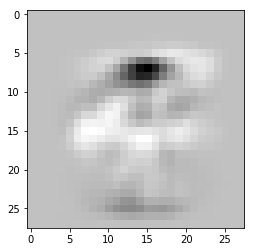

In [310]:
optimizer = GDOptimizer(lr = 0.05, beta = 0.0)
svm = optimize_svm(X_train, y_train, 1.0, optimizer, 100, 500)
y_pred = svm.classify(X_train)
train_acc = (y_pred == y_train).mean()
train_loss = svm.hinge_loss(X_train, y_train)
y_pred = svm.classify(X_test)
test_acc = (y_pred == y_test).mean()
test_loss = svm.hinge_loss(X_test, y_test)
print('alpha = 0.05, C = 1.0, m = 100, T = 500, beta = 0.0')
print('training accuracy: {}, test accuracy: {}'.format(train_acc, test_acc))
print('training loss: {}, \ntest loss: {}'.format(np.mean(train_loss), np.mean(test_loss)))
plt.imshow(svm.w[1:].reshape(28, 28), cmap='gray')
plt.show()

alpha = 0.05, C = 1.0, m = 100, T = 500, beta = 0.1
training accuracy: 0.927891156462585, test accuracy: 0.9220166848023214
training loss: 0.29247342549848304, 
test loss: 0.29536689916718345


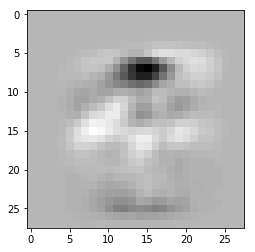

In [332]:
optimizer = GDOptimizer(lr = 0.05, beta = 0.1)
svm = optimize_svm(X_train, y_train, 1.0, optimizer, 100, 500)
y_pred = svm.classify(X_train)
train_acc = (y_pred == y_train).mean()
train_loss = svm.hinge_loss(X_train, y_train)
y_pred = svm.classify(X_test)
test_acc = (y_pred == y_test).mean()
test_loss = svm.hinge_loss(X_test, y_test)
print('alpha = 0.05, C = 1.0, m = 100, T = 500, beta = 0.1')
print('training accuracy: {}, test accuracy: {}'.format(train_acc, test_acc))
print('training loss: {}, \ntest loss: {}'.format(np.mean(train_loss), np.mean(test_loss)))
plt.imshow(svm.w[1:].reshape(28, 28), cmap='gray')
plt.show()